<a href="https://colab.research.google.com/github/choco721/ALGORITMIA/blob/Jupiter-definitivo/TP2Algoritmia_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Celda 1 — Instalación (Colab)

In [11]:
# Instala dependencias (si ya están, no pasa nada)
!pip -q install pyedflib mne

Celda 2 — Configuración inicial (rutas, summary y tiempos)

In [12]:
import os, math, numpy as np, pandas as pd, matplotlib.pyplot as plt
from IPython.display import display

# Rutas (ajustá si subís a otra carpeta en Colab)
EDF_PATH = "/content/chb10_38.edf"
SUMMARY_PATH = "/content/chb10-summary.txt"

FS_HINT = 256.0  # Hz (esperado en chb10)

# Intentar leer start/end del summary
SEIZURE_START_SEC = None
SEIZURE_END_SEC = None

if os.path.exists(SUMMARY_PATH):
    with open(SUMMARY_PATH, "r", encoding="utf-8", errors="ignore") as f:
        txt = f.read()
    import re
    block_pat = r"File Name:\s*chb10_38\.edf[\s\S]*?(?=File Name:|$)"
    mblock = re.search(block_pat, txt)
    if mblock:
        block = mblock.group(0)
        ms = re.search(r"Seizure Start Time:\s*(\d+)", block)
        me = re.search(r"Seizure End Time:\s*(\d+)", block)
        if ms and me:
            SEIZURE_START_SEC = float(ms.group(1))
            SEIZURE_END_SEC = float(me.group(1))

# Fallback manual si no hay summary o no se pudo parsear
if SEIZURE_START_SEC is None or SEIZURE_END_SEC is None:
    SEIZURE_START_SEC = 4618.0
    SEIZURE_END_SEC   = 4707.0

# Ventanas pedidas por el práctico
BEFORE_SEC = 120.0
AFTER_SEC  = 120.0

print("Seizure start:", SEIZURE_START_SEC, " | Seizure end:", SEIZURE_END_SEC)


Seizure start: 4618.0  | Seizure end: 4707.0


Celda 3 — Funciones helper (carga EDF, segmentación, descriptores, autocorr, AIC)

In [13]:
from typing import Tuple, Dict

# Pre/Post/Invariantes y complejidad:
# Pre: edf_path válido; el archivo existe.
# Post: data es float o convertible; dimensiones coherentes; fs > 0.
# Complejidad: O(C·N) en lectura + parseo de headers.

def load_edf_signals(edf_path: str, fs_hint: float = FS_HINT) -> Tuple[np.ndarray, list, float]:
    """Carga EDF con pyedflib (preferido) o MNE (fallback) y retorna (data(C,N), ch_names, fs)."""
    try:
        from pyedflib import highlevel
        data, signal_headers, header = highlevel.read_edf(edf_path)
        data = np.array(data)
        ch_names = [sh.get("label", f"ch{i}") for i, sh in enumerate(signal_headers)]
        fs_list = [sh.get("sample_rate", fs_hint) for sh in signal_headers]
        if len(set(fs_list)) == 1:
            fs = float(fs_list[0])
        else:
            vals, cnts = np.unique(np.array(fs_list), return_counts=True)
            fs = float(vals[np.argmax(cnts)]) if len(vals) else float(fs_hint)
        return data, ch_names, fs
    except Exception:
        import mne
        raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
        data = raw.get_data()
        ch_names = raw.ch_names
        fs = float(raw.info["sfreq"])
        return data, ch_names, fs

# Pre/Post/Complejidad:
# Pre: 0 ≤ start_sec < end_sec, fs > 0.
# Post: X.shape = (C, t1-t0).
# Complejidad: O(C·(t1−t0)) (copia defensiva evita aliasing).

def segment_by_time(data: np.ndarray, fs: float, start_sec: float, end_sec: float) -> Tuple[np.ndarray, int, int]:
    n = data.shape[1]
    t0 = max(0, int(round(start_sec * fs)))
    t1 = min(n, int(round(end_sec   * fs)))
    return data[:, t0:t1].copy(), t0, t1

# Complejidad: O(C·N).
# Invariante: la media por canal del resultado es ~0 (salvo redondeo).

def demean_per_channel(X: np.ndarray) -> np.ndarray:
    return X - X.mean(axis=1, keepdims=True)

# Complejidad: O(C·N).
# Salida: dict con np.ndarray de longitud C.

def descriptors_per_channel(X: np.ndarray) -> Dict[str, np.ndarray]:
    return {
        "var": X.var(axis=1, ddof=0),
        "std": X.std(axis=1, ddof=0),
        "mad0": np.mean(np.abs(X), axis=1),
    }

# Complejidad:
# np.cov ~ O(C²·N) (cuando N ≫ C, lineal en N por cada par de canales).
# Tamaño de salida: C×C.

def covariance_and_corr(X: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    cov = np.cov(X)
    std = np.sqrt(np.diag(cov)) + 1e-12
    corr = cov / np.outer(std, std)
    corr[np.isnan(corr)] = 0.0
    return cov, corr

# Complejidad: O(C·N log N).

def autocorr_fft_features(X: np.ndarray, fs: float, max_sec: float = 1.0) -> Dict[str, np.ndarray]:
    """Devuelve por canal: ac_max_abs y ac_mean_abs para lags 1..fs*max_sec, usando FFT."""
    n_ch, n = X.shape
    L = int(min(fs * max_sec, n - 1))
    ac_max_abs = np.zeros(n_ch)
    ac_mean_abs = np.zeros(n_ch)
    for c in range(n_ch):
        x = X[c] - X[c].mean()
        nfft = 1 << int(np.ceil(np.log2(2 * len(x) - 1)))
        fx = np.fft.rfft(x, n=nfft)
        ac = np.fft.irfft(fx * np.conj(fx), n=nfft).real[:len(x)]
        ac0 = ac[0] + 1e-12
        r = ac / ac0
        vals = np.abs(r[1:L + 1]) if L >= 1 else np.array([0.0])
        ac_max_abs[c] = float(vals.max()) if vals.size > 0 else 0.0
        ac_mean_abs[c] = float(vals.mean()) if vals.size > 0 else 0.0
    return {"ac_max_abs": ac_max_abs, "ac_mean_abs": ac_mean_abs}

# Complejidad: O(N) por evaluación de verosimilitud (muy eficiente).

def aic_normal_vs_laplace(x: np.ndarray) -> Dict[str, Dict[str, float]]:
    x = np.asarray(x).ravel()
    if x.size == 0:
        return {"mejor": "normal",
                "normal": {"mu": 0.0, "sigma": 1.0, "aic": float("inf")},
                "laplace": {"mu": 0.0, "b": 1.0, "aic": float("inf")}}
    mu_n = float(np.mean(x)); sigma_n = float(np.std(x, ddof=0)); sigma_n = max(sigma_n, 1e-12)
    ll_n = -0.5 * np.sum(((x - mu_n) / sigma_n) ** 2) - x.size * (0.5 * math.log(2 * math.pi) + math.log(sigma_n))
    aic_n = 2 * 2 - 2 * ll_n
    mu_l = float(np.median(x)); b_l = float(np.mean(np.abs(x - mu_l))); b_l = max(b_l, 1e-12)
    ll_l = -x.size * math.log(2 * b_l) - (1.0 / b_l) * np.sum(np.abs(x - mu_l))
    aic_l = 2 * 2 - 2 * ll_l
    return {
        "mejor": "normal" if aic_n < aic_l else "laplace",
        "normal": {"mu": mu_n, "sigma": sigma_n, "aic": float(aic_n)},
        "laplace": {"mu": mu_l, "b": b_l, "aic": float(aic_l)},
    }


Celda 4 — Carga y segmentación (Escenario 1)

In [14]:
data, ch_names, fs = load_edf_signals(EDF_PATH, fs_hint=FS_HINT)
n_channels, n_samples = data.shape

before_start = max(0.0, SEIZURE_START_SEC - BEFORE_SEC)
before_end   = SEIZURE_START_SEC
crisis_start = SEIZURE_START_SEC
crisis_end   = SEIZURE_END_SEC
after_start  = SEIZURE_END_SEC
after_end    = SEIZURE_END_SEC + AFTER_SEC

seg_before, b0, b1 = segment_by_time(data, fs, before_start, before_end)
seg_crisis, c0, c1 = segment_by_time(data, fs, crisis_start, crisis_end)
seg_after,  a0, a1 = segment_by_time(data, fs, after_start, after_end)

seg_before = demean_per_channel(seg_before)
seg_crisis = demean_per_channel(seg_crisis)
seg_after  = demean_per_channel(seg_after)

len_before_s = (b1 - b0) / fs
len_crisis_s = (c1 - c0) / fs
len_after_s  = (a1 - a0) / fs

print(f"FS: {fs} Hz | Canales: {n_channels} | Muestras totales: {n_samples}")
print(f"Duraciones → Before: {len_before_s:.1f}s | Crisis: {len_crisis_s:.1f}s | After: {len_after_s:.1f}s")


FS: 256.0 Hz | Canales: 23 | Muestras totales: 1843200
Duraciones → Before: 120.0s | Crisis: 89.0s | After: 120.0s


Celda 5 — Descriptores y matrices (Escenario 1)

In [15]:
desc_before = descriptors_per_channel(seg_before)
desc_crisis = descriptors_per_channel(seg_crisis)
desc_after  = descriptors_per_channel(seg_after)

cov_b, corr_b = covariance_and_corr(seg_before)
cov_c, corr_c = covariance_and_corr(seg_crisis)
cov_a, corr_a = covariance_and_corr(seg_after)

ac_b = autocorr_fft_features(seg_before, fs, max_sec=1.0)
ac_c = autocorr_fft_features(seg_crisis, fs, max_sec=1.0)
ac_a = autocorr_fft_features(seg_after, fs, max_sec=1.0)

df_block_stats = pd.DataFrame({
    "channel": ch_names,
    "var_before": desc_before["var"], "var_crisis": desc_crisis["var"], "var_after": desc_after["var"],
    "std_before": desc_before["std"],  "std_crisis":  desc_crisis["std"],  "std_after":  desc_after["std"],
    "mad0_before": desc_before["mad0"],"mad0_crisis": desc_crisis["mad0"],"mad0_after": desc_after["mad0"],
    "ac_max_abs_before": ac_b["ac_max_abs"], "ac_max_abs_crisis": ac_c["ac_max_abs"], "ac_max_abs_after": ac_a["ac_max_abs"],
    "ac_mean_abs_before": ac_b["ac_mean_abs"],"ac_mean_abs_crisis":ac_c["ac_mean_abs"],"ac_mean_abs_after":ac_a["ac_mean_abs"],
})

print("Escenario 1 — Descriptores por canal (primeras 10 filas):")
display(df_block_stats.head(23))

print("\nMatrices de correlación (Pearson, lag 0) — tamaños:")
print("Before:", corr_b.shape, "| Crisis:", corr_c.shape, "| After:", corr_a.shape)


Escenario 1 — Descriptores por canal (primeras 10 filas):


,channel,var_before,var_crisis,var_after,std_before,std_crisis,std_after,mad0_before,mad0_crisis,mad0_after,ac_max_abs_before,ac_max_abs_crisis,ac_max_abs_after,ac_mean_abs_before,ac_mean_abs_crisis,ac_mean_abs_after
0,FP1-F7,7105.786608,16149.113983,6031.615138,84.295828,127.079164,77.663474,64.642398,93.668381,58.958642,0.963181,0.982909,0.986480,0.111204,0.072688,0.196631
1,F7-T7,9403.791025,42007.751809,12674.726661,96.973146,204.957927,112.582089,75.187495,150.557694,87.373282,0.974504,0.977737,0.963939,0.100948,0.084336,0.259389
2,T7-P7,5050.030978,62127.143728,7132.231258,71.063570,249.253172,84.452538,54.477483,181.561336,62.196369,0.946155,0.972525,0.830688,0.093824,0.117786,0.143942
3,P7-O1,7898.646730,59333.608225,13825.412290,88.874331,243.584910,117.581513,68.841898,171.704862,81.345757,0.955070,0.959206,0.920849,0.126111,0.090063,0.190852
4,FP1-F3,16040.316234,30920.852351,12747.252654,126.650370,175.843261,112.903732,99.601103,129.744234,84.545693,0.975796,0.987933,0.996454,0.123029,0.163644,0.297122
5,F3-C3,12736.067493,49016.483704,17710.821884,112.854187,221.396666,133.082012,89.386944,154.748258,100.691897,0.994774,0.988963,0.998391,0.117485,0.110560,0.288193
6,C3-P3,5373.846829,25009.417427,6079.057726,73.306527,158.143661,77.968312,57.151126,108.219040,58.219212,0.994318,0.983170,0.996789,0.110212,0.083185,0.237763
7,P3-O1,8081.711631,81765.804964,13858.793450,89.898341,285.947207,117.723377,69.904195,200.160329,83.077739,0.992063,0.979505,0.995281,0.179906,0.089036,0.283013
8,FP2-F4,14438.266770,59366.048882,9914.473856,120.159339,243.651491,99.571451,95.624773,170.895608,78.444560,0.967235,0.990200,0.996610,0.122606,0.194779,0.155758
9,F4-C4,6086.783796,42389.166934,8647.423591,78.017843,205.886296,92.991524,61.903354,133.567113,73.511613,0.990709,0.996309,0.996816,0.134322,0.130018,0.159684



Matrices de correlación (Pearson, lag 0) — tamaños:
Before: (23, 23) | Crisis: (23, 23) | After: (23, 23)


Celda 6 — Umbrales por canal (desde Crisis)

In [16]:
MARGIN = 0.05  # ±5%
thr = {}
for ch in range(n_channels):
    v_min, v_max = float(np.min(desc_crisis["var"][ch])),  float(np.max(desc_crisis["var"][ch]))
    m_min, m_max = float(np.min(desc_crisis["mad0"][ch])), float(np.max(desc_crisis["mad0"][ch]))
    thr[ch] = {
        "var_range":  (v_min * (1 - MARGIN), v_max * (1 + MARGIN)),
        "mad0_range": (m_min * (1 - MARGIN), m_max * (1 + MARGIN)),
    }

# Mostrar algunos canales de ejemplo:
print("Umbrales (var y |x| medio) — ejemplos:")
for ch in [0, min(1, n_channels-1), min(2, n_channels-1)]:
    print(ch_names[ch], "→", thr[ch])


Umbrales (var y |x| medio) — ejemplos:
FP1-F7 → {'var_range': (15341.658284169876, 16956.56968250355), 'mad0_range': (88.98496158699628, 98.35179964878536)}
F7-T7 → {'var_range': (39907.36421814128, 44108.13939899827), 'mad0_range': (143.02980899911302, 158.0855783674407)}
T7-P7 → {'var_range': (59020.78654115005, 65233.500913902695), 'mad0_range': (172.4832696383505, 190.63940328449266)}


Celda 7 — Escenario 2 (ventanas 1 s), detección y retardo

In [17]:
# Concateno el bloque total centrado
total_concat = np.concatenate([seg_before, seg_crisis, seg_after], axis=1)
N_total = total_concat.shape[1]

# Ventana de 1 s y paso de 1 s
win = int(round(1.0 * fs))
step = int(round(1.0 * fs))

var_ts, mad_ts, t_centers = [], [], []
for t0 in range(0, N_total - win + 1, step):
    t1 = t0 + win
    Xw = total_concat[:, t0:t1]
    d = descriptors_per_channel(Xw)
    var_ts.append(d["var"]); mad_ts.append(d["mad0"])
    t_centers.append((t0 + t1) / 2.0 / fs)

var_ts = np.stack(var_ts, axis=0)  # (n_windows, n_channels)
mad_ts = np.stack(mad_ts, axis=0)
t_centers = np.array(t_centers)

t_before = len_before_s
t_crisis_end = len_before_s + len_crisis_s

det_rows = []
for ch in range(n_channels):
    vmin, vmax = thr[ch]["var_range"]
    mmin, mmax = thr[ch]["mad0_range"]
    mask = (var_ts[:, ch] >= vmin) & (var_ts[:, ch] <= vmax) & (mad_ts[:, ch] >= mmin) & (mad_ts[:, ch] <= mmax)
    idx = np.where(mask & (t_centers >= t_before))[0]
    if idx.size > 0:
        first_time = float(t_centers[idx[0]])
        delay = first_time - t_before
        detected = True
    else:
        first_time = float('nan')
        delay = float('nan')
        detected = False
    det_rows.append({"channel": ch_names[ch], "first_detection_s": first_time, "delay_s": delay, "detected": detected})

df_detection = pd.DataFrame(det_rows).sort_values("delay_s", na_position="last")

print("Escenario 2 — Detección por canal (primeras 10 filas):")
display(df_detection.head(7))

# Top-5 por menor delay
df_top5 = df_detection.nsmallest(5, "delay_s")
print("\nTop-5 canales (menor retardo):")
display(df_top5)


Escenario 2 — Detección por canal (primeras 10 filas):


,channel,first_detection_s,delay_s,detected
20,FT9-FT10,124.5,4.5,True
3,P7-O1,141.5,21.5,True
13,F8-T8,160.5,40.5,True
15,P8-O2,173.5,53.5,True
11,P4-O2,177.5,57.5,True
4,FP1-F3,207.5,87.5,True
7,P3-O1,207.5,87.5,True



Top-5 canales (menor retardo):


,channel,first_detection_s,delay_s,detected
20,FT9-FT10,124.5,4.5,True
3,P7-O1,141.5,21.5,True
13,F8-T8,160.5,40.5,True
15,P8-O2,173.5,53.5,True
11,P4-O2,177.5,57.5,True


Celda 7B — Sliding descriptor (modelos alternativos) con colores

Usando modelo: Varianza + Desviación Estándar


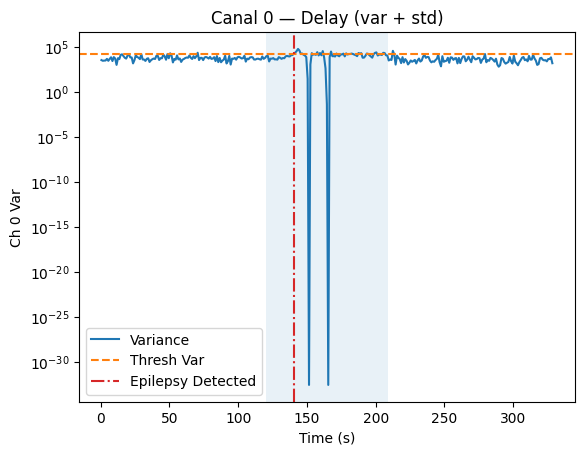

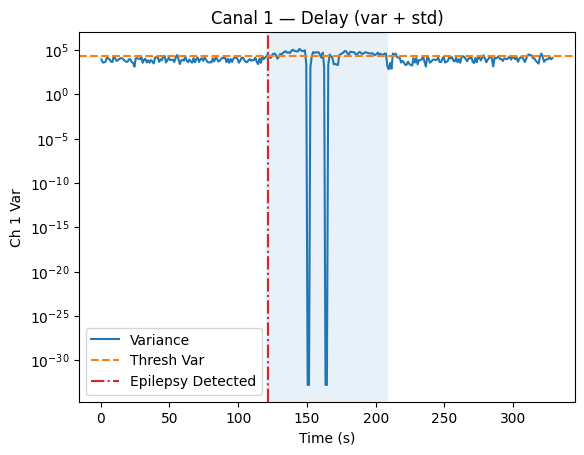

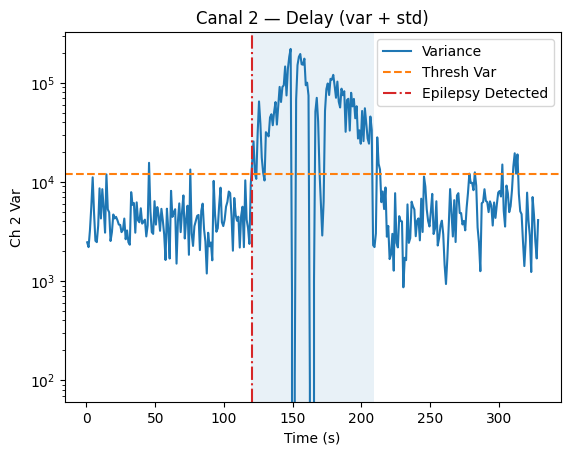

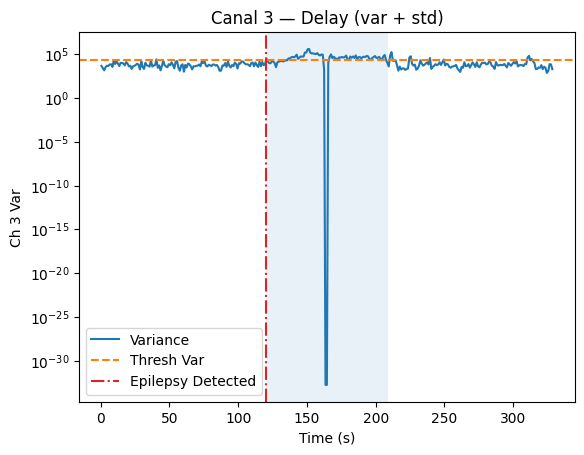

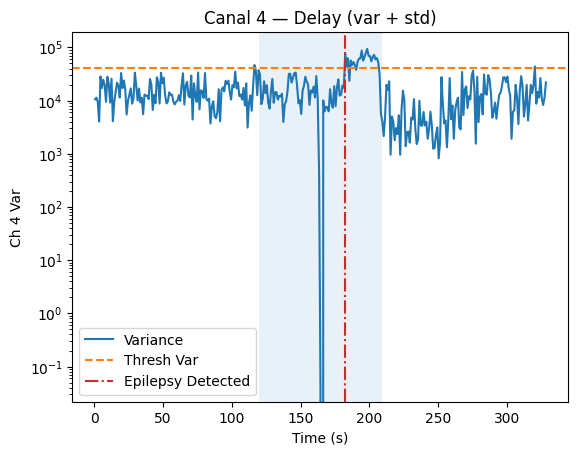

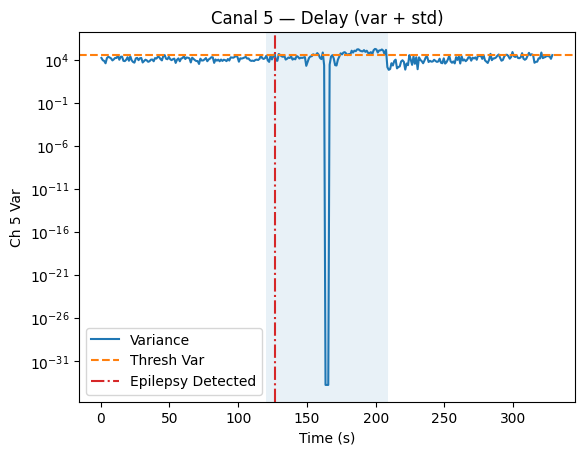

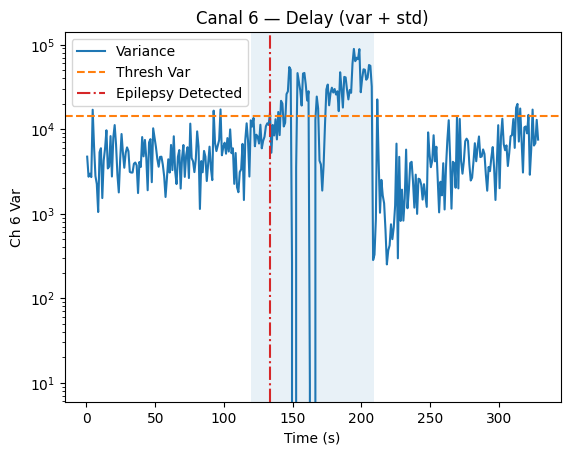

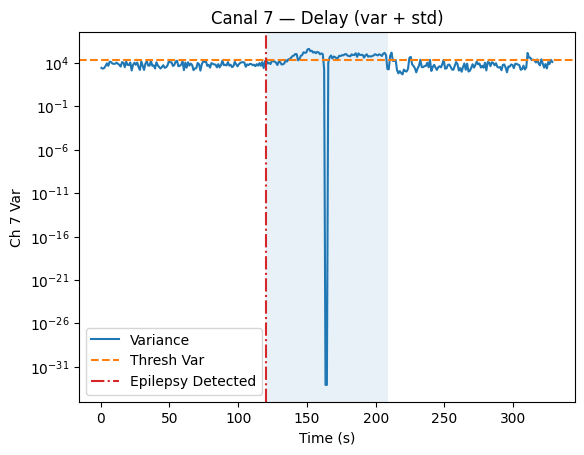

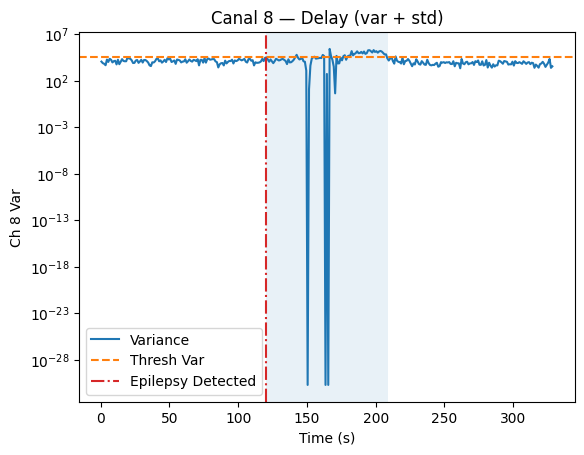

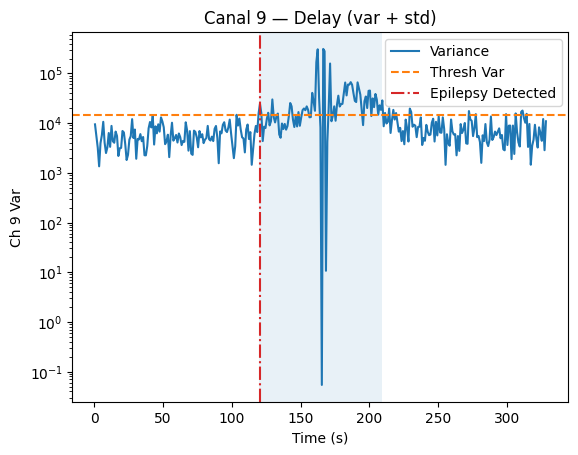

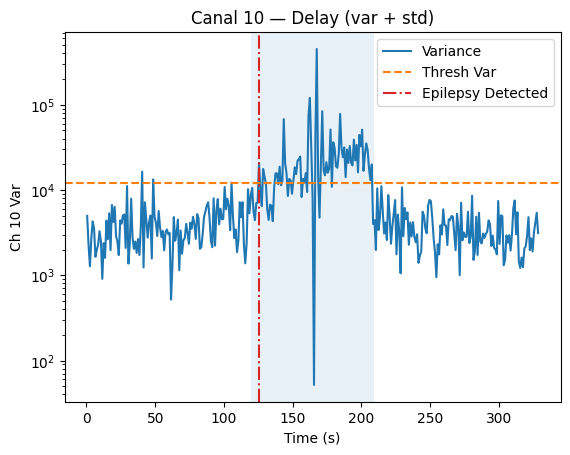

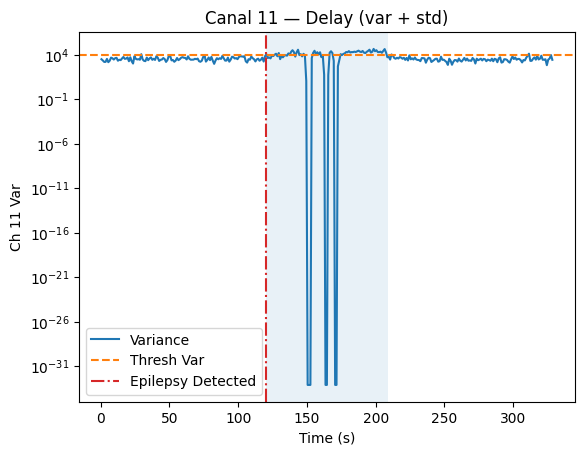

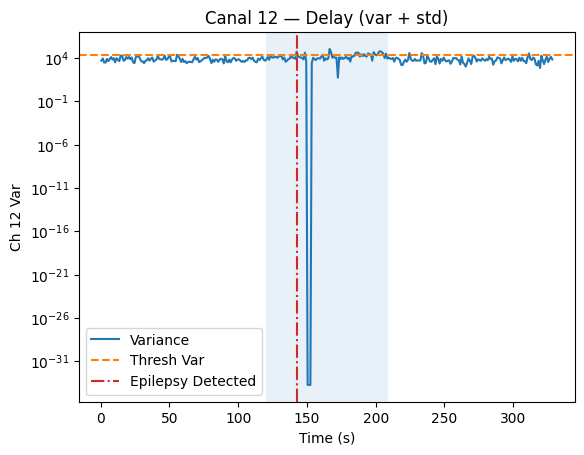

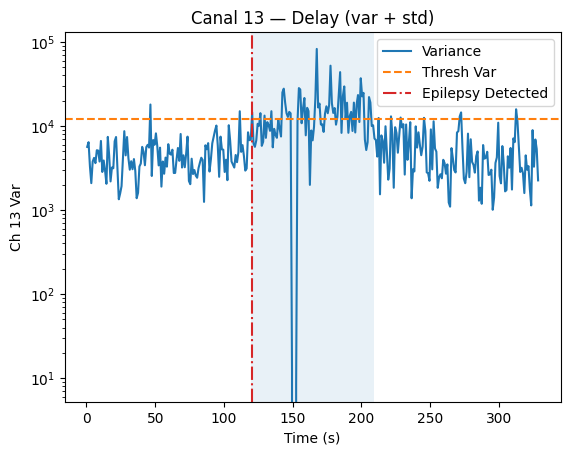

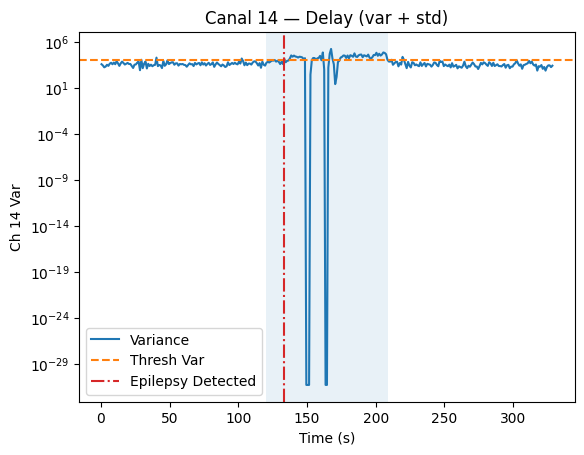

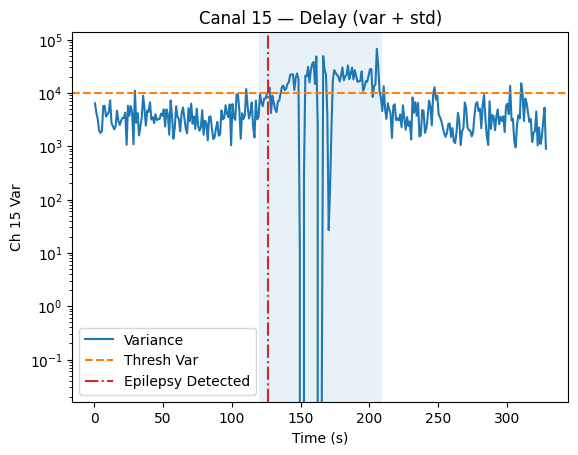

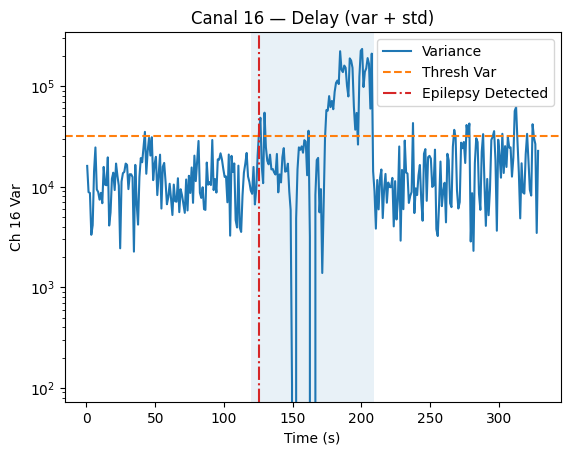

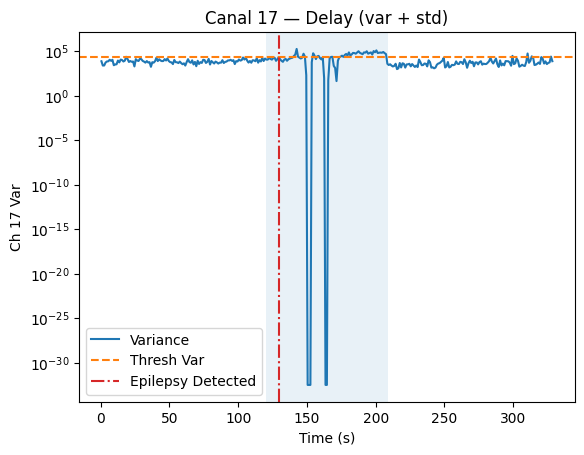

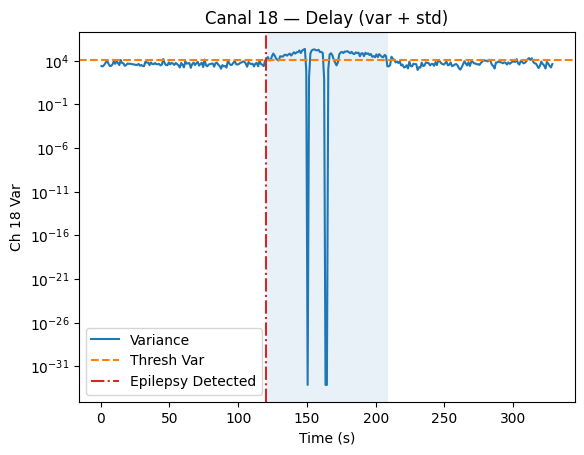

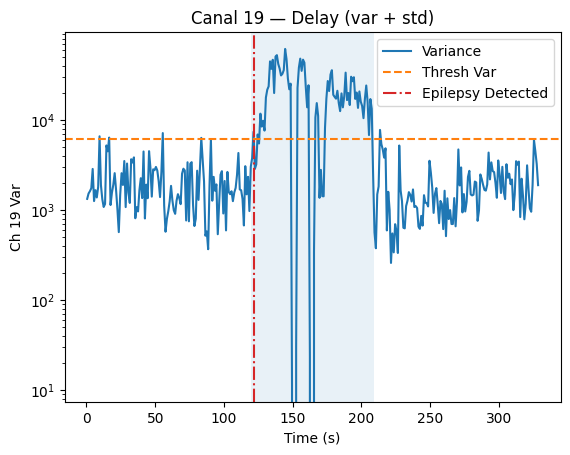

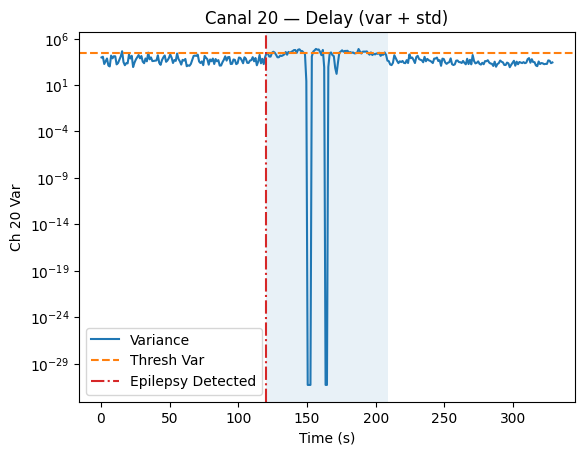

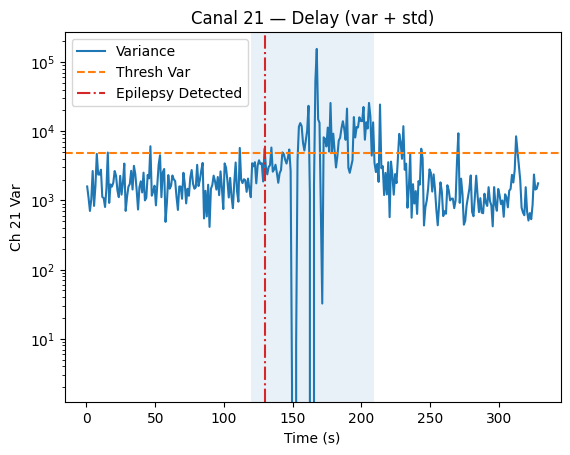

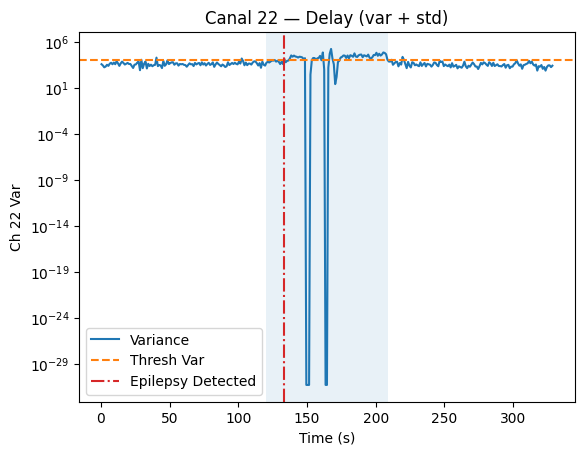

Resumen detección (ordenado por menor delay):
 channel      thr_var  detected  detection_time  detection_delay_s
       3 21815.094027      True           120.5                0.5
       2 11937.157197      True           120.5                0.5
       7 20829.710186      True           120.5                0.5
       8 32319.110266      True           120.5                0.5
      13 12009.214503      True           120.5                0.5
      11  9160.040052      True           120.5                0.5
       9 14843.429507      True           120.5                0.5
      18 11937.157197      True           120.5                0.5
      20 26334.291188      True           120.5                0.5
      19  6194.149322      True           121.5                1.5
       1 23106.780497      True           121.5                1.5
      10 11959.317451      True           125.5                5.5
      16 31939.456399      True           125.5                5.5
      15  9753.8

In [18]:
# Requisitos previos: fs, n_channels, seg_before, seg_crisis, seg_after, len_before_s, len_crisis_s ya definidos.

# 1) Armar el bloque total por canal
total_concat = np.concatenate([seg_before, seg_crisis, seg_after], axis=1)  # (n_channels, N_total)

# 2) Estructura de segments
segments = {ch: {'total': total_concat[ch]} for ch in range(n_channels)}

# 3) Referencias temporales
before_sec = float(len_before_s)          # inicio real de la crisis en el eje total
crisis_duration_sec = float(len_crisis_s) # duración de la crisis

# 4) Parámetros de sliding (para 1 s exacto: window_size=int(fs); step=int(fs))
window_size = int(fs)
step = int(fs)
selected_model = 'var_std'   # opciones: 'var_autocorr' | 'var_std' | 'var_cov'

# 5) Rutina sliding
def sliding_descriptor(signal, window_size, step, model='var_autocorr'):
    assert isinstance(window_size, int) and window_size > 0
    assert isinstance(step, int) and step > 0
    signal = np.asarray(signal).ravel()
    assert signal.size > 0

    variances, stds, autocorrs, covs, times = [], [], [], [], []
    previous_windows = []

    for start in range(0, len(signal) - window_size + 1, step):
        win = signal[start:start + window_size]
        var = np.var(win)
        std = np.std(win)

        if len(win) > 1:
            mean_win = np.mean(win)
            autocov_lag0 = np.mean((win - mean_win) ** 2)
            autocov_lag1 = np.mean((win[:-1] - mean_win) * (win[1:] - mean_win))
            autocorr = autocov_lag1 / autocov_lag0 if autocov_lag0 != 0 else np.nan
        else:
            autocorr = np.nan

        variances.append(var)
        stds.append(std)
        autocorrs.append(autocorr)
        times.append((start + window_size / 2) / fs)

        if model == 'var_cov':
            if previous_windows:
                prev_win = previous_windows[-1]
                if len(win) == len(prev_win) == window_size:
                    mean_prev = np.mean(prev_win)
                    cov = np.mean((win - np.mean(win)) * (prev_win - mean_prev))
                else:
                    cov = np.nan
            else:
                cov = np.nan
            previous_windows.append(win.copy())
            covs.append(cov)
        else:
            covs.append(np.nan)

        if len(previous_windows) > 1:
            previous_windows.pop(0)

    return (np.array(times), np.array(variances), np.array(stds),
            np.array(autocorrs), np.array(covs))

# 6) Plot canal a canal con colores diferenciados
num_channels = n_channels

models = {
    'var_autocorr': 'Varianza + Autocorrelación',
    'var_std': 'Varianza + Desviación Estándar',
    'var_cov': 'Varianza + Covarianza'
}
print(f"Usando modelo: {models.get(selected_model, selected_model)}")

detection_summary = []

for ch in range(num_channels):
    total_sig = segments[ch]['total']
    times, vars_, stds, autocorrs, covs = sliding_descriptor(
        total_sig, window_size, step, model=selected_model
    )

    # — Gráfico 1 por canal: Varianza + umbral + marca de detección —
    plt.figure()

    # Varianza (AZUL)
    plt.plot(times, vars_, label='Variance', color='tab:blue')

    # Franja de crisis (sin label para limpiar leyenda)
    plt.axvspan(before_sec, before_sec + crisis_duration_sec, alpha=0.1)

    plt.ylabel(f'Ch {ch} Var')
    plt.yscale('log')

    # Umbral de Varianza (NARANJA, punteado)
    before_mask = times < before_sec
    before_vars = vars_[before_mask]
    if len(before_vars) > 0:
        mean_var_before = np.mean(before_vars)
        std_var_before = np.std(before_vars)
    else:
        mean_var_before, std_var_before = 0.0, 0.0
    thresh_var = mean_var_before + 3.0 * std_var_before
    plt.axhline(thresh_var, color='tab:orange', linestyle='--', label='Thresh Var')

    # Lógica de detección por modelo
    if selected_model == 'var_autocorr':
        before_autocorrs = autocorrs[before_mask]
        if len(before_autocorrs) > 0:
            mean_autocorr_before = np.mean(before_autocorrs)
            std_autocorr_before = np.std(before_autocorrs)
            thresh_autocorr = mean_autocorr_before - 2.0 * std_autocorr_before
        else:
            thresh_autocorr = np.nan

        if not np.isnan(thresh_autocorr):
            detect_idx = np.where((times >= before_sec) &
                                  (vars_ > thresh_var) &
                                  (autocorrs < thresh_autocorr))[0]
        else:
            detect_idx = np.where((times >= before_sec) & (vars_ > thresh_var))[0]
        delay_label = 'Delay (var + autocorr)'

    elif selected_model == 'var_std':
        detect_idx = np.where((times >= before_sec) & (vars_ > thresh_var))[0]
        delay_label = 'Delay (var + std)'

    elif selected_model == 'var_cov':
        before_covs = covs[before_mask]
        if len(before_covs) > 0:
            mean_cov_before = np.mean(before_covs)
            std_cov_before = np.std(before_covs)
            thresh_cov = mean_cov_before - 2.0 * std_cov_before
        else:
            thresh_cov = np.nan

        if not np.isnan(thresh_cov):
            detect_idx = np.where((times >= before_sec) &
                                  (vars_ > thresh_var) &
                                  (covs < thresh_cov))[0]
        else:
            detect_idx = np.where((times >= before_sec) & (vars_ > thresh_var))[0]
        delay_label = 'Delay (var + cov)'

    # Marca de detección (ROJO, punto-guión)
    if len(detect_idx) > 0:
        detect_time = float(times[detect_idx[0]])
        delay = detect_time - before_sec
        detected = True
        plt.axvline(detect_time, color='tab:red', linestyle='-.', label='Epilepsy Detected')
    else:
        detect_time = float('nan')
        delay = float('nan')
        detected = False

    plt.title(f"Canal {ch} — {delay_label}")
    plt.xlabel('Time (s)')

    # Leyenda sin duplicados
    handles, labels = plt.gca().get_legend_handles_labels()
    seen = set(); h_unique, l_unique = [], []
    for h, l in zip(handles, labels):
        if l not in seen and l != '':
            h_unique.append(h); l_unique.append(l); seen.add(l)
    plt.legend(h_unique, l_unique)

    plt.show()

    detection_summary.append({
        'channel': ch,
        'thr_var': thresh_var,
        'detected': detected,
        'detection_time': detect_time,
        'detection_delay_s': delay
    })

# Resumen ordenado por menor delay + Top-5
det_df = pd.DataFrame(detection_summary).sort_values('detection_delay_s', na_position='last')
print("Resumen detección (ordenado por menor delay):")
print(det_df.to_string(index=False))

top5 = det_df.nsmallest(5, 'detection_delay_s')
print("\nTop-5 canales (menor retardo):")
print(top5.to_string(index=False))


Celda 8 — PDFs (Normal vs Laplace), plots pedidos

Canal representativo: FT9-FT10 | PDF elegida por mayoría: laplace

Parámetros de la PDF elegida (primeras 10 filas):


,channel,block,param_x,param_y
0,FP1-F7,Before,-4.882383,64.511657
1,FP1-F7,Crisis,0.272976,93.651943
2,FP1-F7,After,-0.645375,58.956158
3,F7-T7,Before,2.715526,75.160199
4,F7-T7,Crisis,0.100372,150.553103
5,F7-T7,After,-1.758127,87.362103
6,T7-P7,Before,-0.015129,54.477469
7,T7-P7,Crisis,-0.152102,181.552738
8,T7-P7,After,1.388813,62.182502
9,P7-O1,Before,0.112428,68.840793


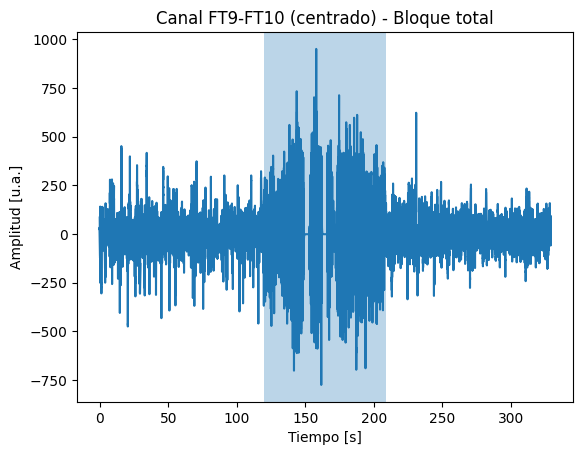

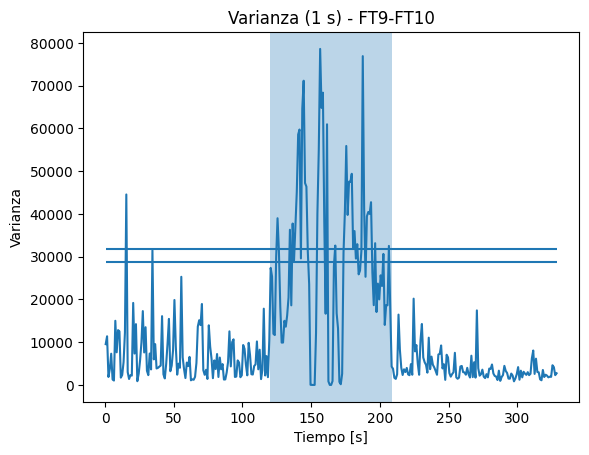

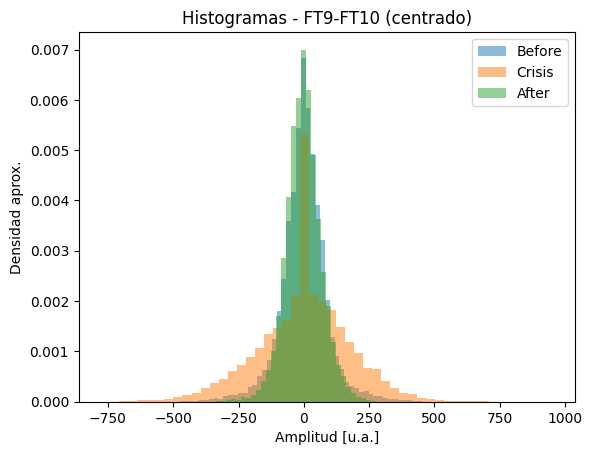

/tmp/ipython-input-2041915758.py:71: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([desc_before["var"], desc_crisis["var"], desc_after["var"]], labels=["Before","Crisis","After"])


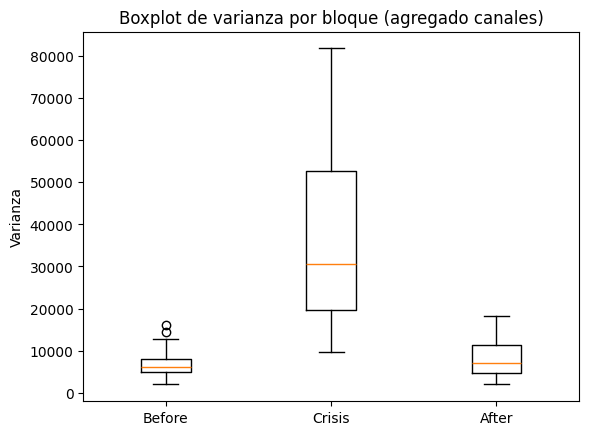

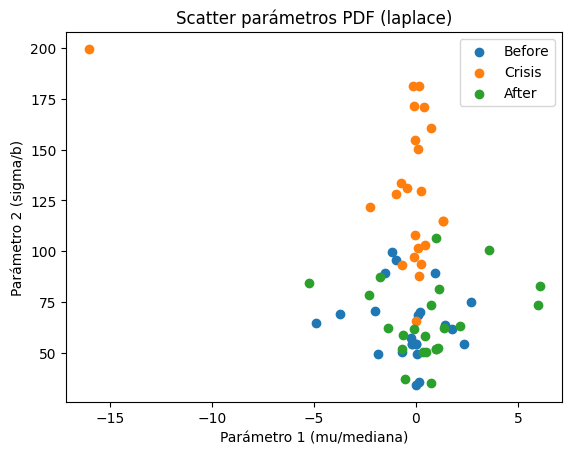

In [19]:
# Canal representativo: menor delay (de df_detection si existe)
if 'df_detection' in globals() and df_detection["delay_s"].notna().any():
    best_row = df_detection[df_detection["delay_s"].notna()].iloc[0]
    rep_channel_name = str(best_row["channel"])
    rep_channel_idx = ch_names.index(rep_channel_name)
else:
    rep_channel_idx = 0
    rep_channel_name = ch_names[0]

xB = seg_before[rep_channel_idx]
xC = seg_crisis[rep_channel_idx]
xA = seg_after[rep_channel_idx]

fit_B = aic_normal_vs_laplace(xB)
fit_C = aic_normal_vs_laplace(xC)
fit_A = aic_normal_vs_laplace(xA)
models = [fit_B["mejor"], fit_C["mejor"], fit_A["mejor"]]
chosen_pdf = "normal" if models.count("normal") > models.count("laplace") else "laplace"
print("Canal representativo:", rep_channel_name, "| PDF elegida por mayoría:", chosen_pdf)

# Parámetros de la PDF elegida para TODOS los canales y bloques (solo mostrar)
rows = []
for ch in range(n_channels):
    for block_name, x in [("Before", seg_before[ch]), ("Crisis", seg_crisis[ch]), ("After", seg_after[ch])]:
        fit = aic_normal_vs_laplace(x)
        if chosen_pdf == "normal":
            rows.append({"channel": ch_names[ch], "block": block_name,
                         "param_x": fit["normal"]["mu"], "param_y": fit["normal"]["sigma"]})
        else:
            rows.append({"channel": ch_names[ch], "block": block_name,
                         "param_x": fit["laplace"]["mu"], "param_y": fit["laplace"]["b"]})
df_pdf_params = pd.DataFrame(rows)
print("\nParámetros de la PDF elegida (primeras 10 filas):")
display(df_pdf_params.head(10))

# 1) Señal centrada del canal representativo en bloque total, con crisis sombreada
plt.figure()
total_concat = np.concatenate([seg_before, seg_crisis, seg_after], axis=1)
t_total = np.arange(total_concat.shape[1]) / fs
plt.plot(t_total, total_concat[rep_channel_idx])
plt.axvspan(len_before_s, len_before_s + len_crisis_s, alpha=0.3)
plt.title(f"Canal {rep_channel_name} (centrado) - Bloque total")
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud [u.a.]")
plt.show()

# 2) Varianza por ventana (1 s) con bandas de umbral del canal representativo
plt.figure()
plt.plot(t_centers, var_ts[:, rep_channel_idx])
vmin, vmax = thr[rep_channel_idx]["var_range"]
plt.hlines([vmin, vmax], xmin=t_centers[0], xmax=t_centers[-1])
plt.axvspan(len_before_s, len_before_s + len_crisis_s, alpha=0.3)
plt.title(f"Varianza (1 s) - {rep_channel_name}")
plt.xlabel("Tiempo [s]")
plt.ylabel("Varianza")
plt.show()

# 3) Histogramas por bloque (canal representativo)
plt.figure()
plt.hist(xB, bins=50, alpha=0.5, density=True, label="Before")
plt.hist(xC, bins=50, alpha=0.5, density=True, label="Crisis")
plt.hist(xA, bins=50, alpha=0.5, density=True, label="After")
plt.title(f"Histogramas - {rep_channel_name} (centrado)")
plt.xlabel("Amplitud [u.a.]")
plt.ylabel("Densidad aprox.")
plt.legend()
plt.show()

# 4) Boxplot de varianza por bloque (agregado sobre canales)
plt.figure()
plt.boxplot([desc_before["var"], desc_crisis["var"], desc_after["var"]], labels=["Before","Crisis","After"])
plt.title("Boxplot de varianza por bloque (agregado canales)")
plt.ylabel("Varianza")
plt.show()

# 5) Scatter de parámetros de la PDF elegida (por canal y bloque)
plt.figure()
for blk in ["Before", "Crisis", "After"]:
    sub = df_pdf_params[df_pdf_params["block"] == blk]
    plt.scatter(sub["param_x"], sub["param_y"], label=blk)
plt.title(f"Scatter parámetros PDF ({chosen_pdf})")
plt.xlabel("Parámetro 1 (mu/mediana)")
plt.ylabel("Parámetro 2 (sigma/b)")
plt.legend()
plt.show()


Celda 8B — Ajuste de PDFs extendido (Normal, Laplace, Gamma, Rayleigh)

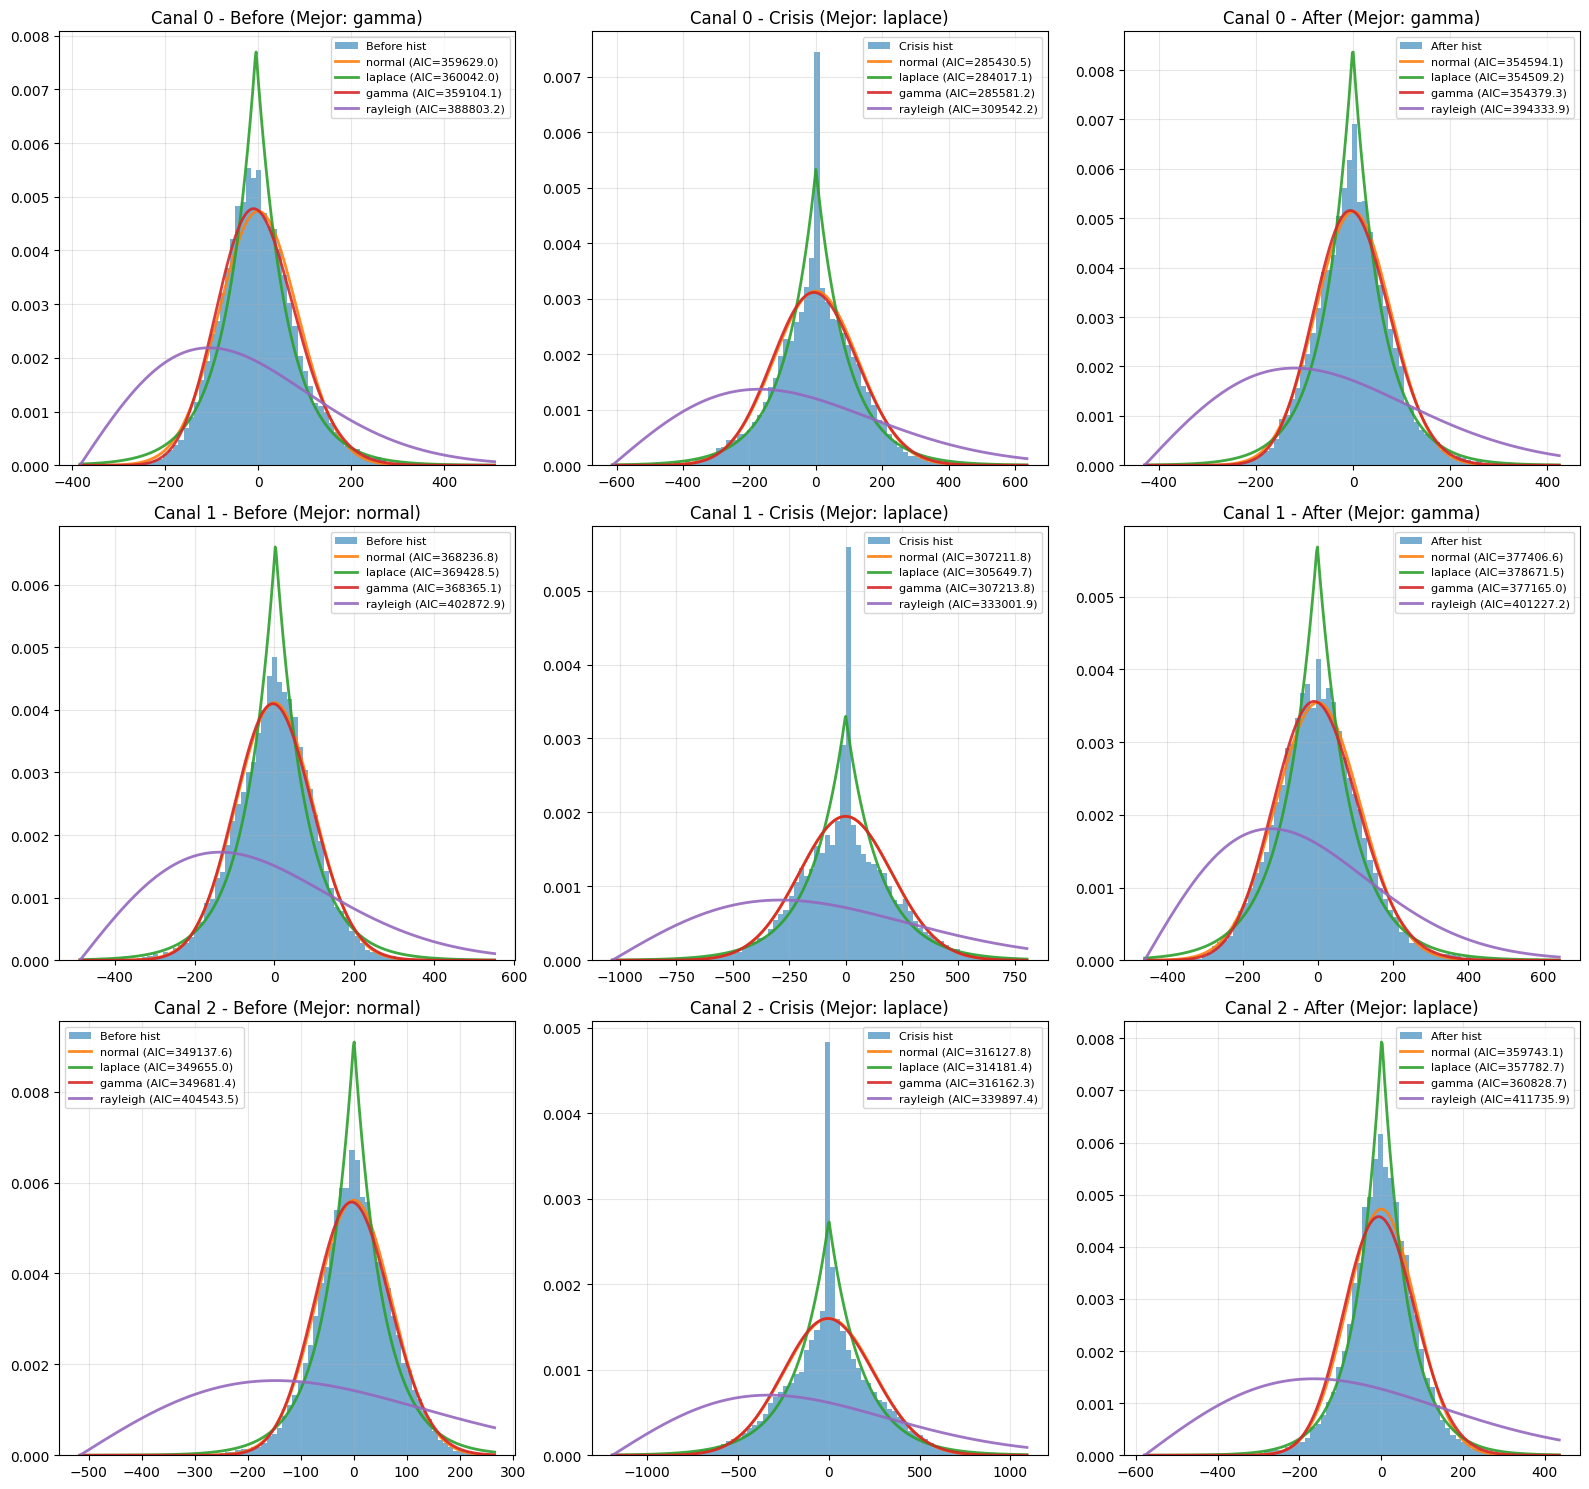

Resumen de mejor ajuste por canal (mostrados) y bloque:


,channel,block,best_dist,AIC,params
2,0,after,gamma,354379.262429,"(185.85390224167338, -1056.9920276490684, 5.68..."
0,0,before,gamma,359104.106289,"(73.37631332794959, -719.1832093480501, 9.8012..."
1,0,crisis,laplace,284017.147848,"(0.27297608758283004, 93.65194262666172)"
5,1,after,gamma,377165.007565,"(124.92156090771272, -1256.6868193580176, 10.0..."
3,1,before,normal,368236.814201,"(1.1546319456101628e-15, 96.97314589832092)"
4,1,crisis,laplace,305649.676177,"(0.1003724739679796, 150.55310326377742)"
8,2,after,laplace,357782.686860,"(1.3888125763125765, 62.18250152625153)"
6,2,before,normal,349137.620929,"(-1.5987211554602255e-15, 71.0635699793218)"
7,2,crisis,laplace,314181.387006,"(-0.15210211137177437, 181.55273799234473)"


In [20]:
from scipy.stats import norm, laplace, gamma, rayleigh

# 1) Estructura requerida: segments_blocks[ch][block]
segments_blocks = {
    ch: {
        'before': seg_before[ch].ravel(),
        'crisis': seg_crisis[ch].ravel(),
        'after' : seg_after[ch].ravel()
    } for ch in range(n_channels)
}

# 2) Distribuciones a testear
distributions_to_test = [
    ('normal',  norm),
    ('laplace', laplace),
    ('gamma',   gamma),
    ('rayleigh', rayleigh)
]

# 3) Cantidad de canales a mostrar (máximo 3 para legibilidad)
n_hist = min(3, n_channels)

# 4) Figura: n_hist filas x 3 columnas (before, crisis, after)
plt.figure(figsize=(16, 5 * n_hist))
results = {}

for i in range(n_hist):  # i = índice de canal visible
    results[i] = {}
    for j, block in enumerate(['before', 'crisis', 'after']):
        data_block = segments_blocks[i][block]
        data_block = data_block[np.isfinite(data_block)]
        n = len(data_block)

        ax = plt.subplot(n_hist, 3, i * 3 + j + 1)
        if n == 0:
            ax.set_title(f'Canal {i} - {block.capitalize()} (sin datos)')
            ax.grid(True, alpha=0.3)
            continue

        # Histograma como densidad
        ax.hist(data_block, bins=80, alpha=0.6, density=True, label=f'{block.capitalize()} hist')

        # Rango para PDFs
        xmin, xmax = np.min(data_block), np.max(data_block)
        if xmin == xmax:
            eps = 1e-9 if xmin == 0 else abs(xmin) * 1e-6
            xmin -= eps; xmax += eps
        x = np.linspace(xmin, xmax, 500)

        best_aic = np.inf
        best_name, best_params = None, None
        results[i][block] = {}

        # Ajuste y AIC
        for name, dist in distributions_to_test:
            try:
                params = dist.fit(data_block)
                ll = np.sum(dist.logpdf(data_block, *params))
                k = len(params)
                aic = 2 * k - 2 * ll  # AIC clásico

                y = dist.pdf(x, *params)
                ax.plot(x, y, lw=2, alpha=0.9, label=f'{name} (AIC={aic:.1f})')

                results[i][block][name] = (aic, params)
                if aic < best_aic:
                    best_aic, best_name, best_params = aic, name, params
            except Exception:
                continue

        ax.set_title(f'Canal {i} - {block.capitalize()} (Mejor: {best_name})')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

# (Opcional) Resumen de “mejor por bloque” para los canales mostrados
summary_rows = []
for i in range(n_hist):
    for block in ['before', 'crisis', 'after']:
        if block in results[i]:
            candidates = results[i][block]
            if candidates:
                best = min(candidates.items(), key=lambda kv: kv[1][0])  # (name, (aic, params))
                summary_rows.append({
                    'channel': i,
                    'block': block,
                    'best_dist': best[0],
                    'AIC': best[1][0],
                    'params': best[1][1]
                })

if summary_rows:
    df_pdf_fit_summary = pd.DataFrame(summary_rows).sort_values(['channel','block'])
    print("Resumen de mejor ajuste por canal (mostrados) y bloque:")
    display(df_pdf_fit_summary)


Celda 9 — Correlación cruzada (faltante de la consigna)

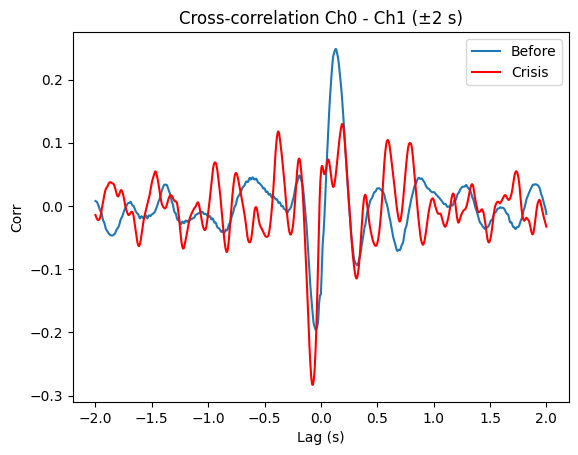

Observación: picos más altos/anchos en Crisis sugieren mayor sincronía entre canales durante la crisis.


In [21]:
# Elegimos dos canales para ejemplo de cross-correlation (podés cambiar indices)
ch_a = 0
ch_b = min(1, n_channels-1)

# Función de correlación cruzada normalizada por bloque
def xcorr_normalized(x, y, max_lag_s=2.0, fs=fs):
    x = x - np.mean(x); y = y - np.mean(y)
    n = len(x)
    max_lag = int(min(max_lag_s*fs, n-1))
    lags = np.arange(-max_lag, max_lag+1)
    # usar modo 'full' y recortar
    corr_full = np.correlate(x, y, mode='full')
    mid = len(corr_full)//2
    corr = corr_full[mid-max_lag:mid+max_lag+1]
    # normalización por energía
    denom = (np.sqrt(np.sum(x**2)) * np.sqrt(np.sum(y**2)) + 1e-12)
    corr = corr / denom
    return lags/fs, corr

# Cross-corr en BEFORE y CRISIS
lags_b, cc_before = xcorr_normalized(seg_before[ch_a], seg_before[ch_b], max_lag_s=2.0, fs=fs)
lags_c, cc_crisis = xcorr_normalized(seg_crisis[ch_a], seg_crisis[ch_b], max_lag_s=2.0, fs=fs)

plt.figure()
plt.plot(lags_b, cc_before, label='Before')
plt.plot(lags_c, cc_crisis, label='Crisis', color = 'red')
plt.title(f'Cross-correlation Ch{ch_a} - Ch{ch_b} (±2 s)')
plt.xlabel('Lag (s)')
plt.ylabel('Corr')
plt.legend()
plt.show()

print("Observación: picos más altos/anchos en Crisis sugieren mayor sincronía entre canales durante la crisis.")


Celda 10 — Interpretación breve de boxplots (texto guía)

In [22]:
# Mini-guía para tu informe (lo imprime en pantalla)
def interpret_boxplot_variance(desc_b, desc_c, desc_a):
    vb, vc, va = desc_b["var"], desc_c["var"], desc_a["var"]
    def stats(x): return np.mean(x), np.median(x), np.std(x)
    mb, medb, sdb = stats(vb); mc, medc, sdc = stats(vc); ma, meda, sda = stats(va)
    print("Interpretación de boxplots (varianza por bloque, agregado sobre canales):\n")
    print(f"- BEFORE: media={mb:.3g}, mediana={medb:.3g}, std={sdb:.3g}")
    print(f"- CRISIS: media={mc:.3g}, mediana={medc:.3g}, std={sdc:.3g}")
    print(f"- AFTER : media={ma:.3g}, mediana={meda:.3g}, std={sda:.3g}\n")
    print("Conclusión típica:")
    print("Durante CRISIS suele observarse mayor dispersión (varianzas más altas y caja/bigotes más extendidos).")
    print("BEFORE y AFTER tienden a ser más compactos. Esto respalda fijar umbrales sobre varianza/|x| medio para detectar el inicio de crisis.")

interpret_boxplot_variance(desc_before, desc_crisis, desc_after)

print("\nNota sobre complejidad y aleatoriedad:")
print("Las ventanas deslizantes requieren evaluar cada muestra de cada ventana: O(N).")
print("Introducir muestreo aleatorio no reduce la complejidad asintótica y perjudica la validez estadística para fijar umbrales.")


Interpretación de boxplots (varianza por bloque, agregado sobre canales):

- BEFORE: media=7.18e+03, mediana=6.09e+03, std=3.69e+03
- CRISIS: media=3.63e+04, mediana=3.07e+04, std=1.91e+04
- AFTER : media=8.2e+03, mediana=7.13e+03, std=4.48e+03

Conclusión típica:
Durante CRISIS suele observarse mayor dispersión (varianzas más altas y caja/bigotes más extendidos).
BEFORE y AFTER tienden a ser más compactos. Esto respalda fijar umbrales sobre varianza/|x| medio para detectar el inicio de crisis.

Nota sobre complejidad y aleatoriedad:
Las ventanas deslizantes requieren evaluar cada muestra de cada ventana: O(N).
Introducir muestreo aleatorio no reduce la complejidad asintótica y perjudica la validez estadística para fijar umbrales.


Interpretación de boxplots (varianza por bloque, agregado sobre canales):

- BEFORE:
media=7.18e+03
mediana=6.09e+03, std=3.69e+03
- CRISIS:
 media=3.63e+04
 mediana=3.07e+04
 std=1.91e+04
- AFTER :
media=8.2e+03
mediana=7.13e+03
std=4.48e+03

Conclusión típica:
Durante CRISIS suele observarse mayor dispersión (varianzas más altas y caja/bigotes más extendidos).

BEFORE y AFTER tienden a ser más compactos. Esto respalda fijar umbrales sobre varianza/|x| medio para detectar el inicio de crisis.

Nota sobre complejidad y aleatoriedad:
Las ventanas deslizantes requieren evaluar cada muestra de cada ventana: O(N).

Introducir muestreo aleatorio no reduce la complejidad asintótica y perjudica la validez estadística para fijar umbrales.


UML